## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀세니움 사용
- 무선청소기 검색에 사용할 URL
    https://search.danawa.com/dsearch.php?query=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&originalQuery=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&previousKeyword=%EB%AC%B4%EC%84%A0%EC%B2%AD%EC%86%8C%EA%B8%B0&checkedInfo=N&volumeType=allvs&page=2&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A
- URL 최소화하면
    https://search.danawa.com/dsearch.php?query=무선청소기&page=2&limit=120&sort=saveDESC&list=list

한페이지가 로드될때 5 초 정도 소요

In [1]:
## 필수 라이브러리 사용등록
from selenium import  webdriver
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse # url encode
from tqdm import tqdm, tqdm_notebook
import time

In [33]:
## 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url =r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

In [34]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

In [35]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [36]:
len(prodItems)

3

In [37]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t','')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [38]:
# 만약에 수가 아닌 문자열이 들어왔을때는 False
prodItems[0].select('input')[1].get('value').isdecimal()

True

##### 다나와 무선청소기 웹크롤링 다시
- 가격외에는 안들어오도록 변환

In [2]:
## 검색어,페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
            'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
            'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [3]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip() # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t','') # 상품 스펙목록 가져오기
            if prodItem.select('input')[1].get('value').isdecimal()==True:
                price = prodItem.select('input')[1].get('value') # 최저가 가져오기
            else:
                price = 0 # 문자열 들어온 것 막음
        
            prodData.append([prodName, specList, price])
        except:
            pass

    return prodData

In [4]:
## 여러페이지 검색후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
startPage = 1
totalPage = 3
prodDataTotal = [] # 최종적으로 저장할 리스트

for page in tqdm(range(startPage,totalPage +1)):
    # 검색 페이지 이동
    url = getSearchPageUrl(keyword,page)
    driver.get(url)
    # 페이지 로딩이 완료될때까지 5초간 대기
    time.sleep(5)

    # 현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems) # 리스트로 추출하는 함수
    
    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList

100%|██████████| 3/3 [00:56<00:00, 18.93s/it]


In [5]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [6]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       360 non-null    object
 1   1       360 non-null    object
 2   2       360 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


In [7]:
dfProdDataTotal.columns = ['제품명','제품스펙','최저가']

In [8]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과2.xlsx',index=False)

##### 크롤링 데이터 전처리

In [10]:
# 저장한 엑셀을 재로드
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDanawa.tail()

,제품명,제품스펙,최저가
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [11]:
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2120 non-null   object
 1   제품스펙    2110 non-null   object
 2   최저가     2120 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.8+ KB


In [ ]:
dfProdDanawa

In [18]:
# 결측치 검색
condition = dfProdDanawa['제품스펙'].isnull() == True

In [19]:
dfProdDanawa[condition]

,제품명,제품스펙,최저가
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0


In [25]:
## 결측치가 있는 행(row)을 삭제
dfProdDanawa = dfProdDanawa.dropna(axis=0)

In [36]:
## 최저가가 0인 제품
condition = dfProdDanawa['최저가'] == 0

In [35]:
# 최저가가 0은 제품 제외한 나머지
dfProdDanawa = dfProdDanawa[condition == False]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2956\119274329.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfProdDanawa = dfProdDanawa[condition == False]


In [41]:
# 행들이 삭제되면서 인덱스가 꼬임. 인덱스 초기화
dfProdDanawa.reset_index(drop=True, inplace=True)

In [60]:
# 결측치, 이상치를 제거한 최종 DF
# 회사명, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2057개가 필수
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2057 non-null   object
 1   제품스펙    2057 non-null   object
 2   최저가     2057 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [50]:
# 회사명, 제품명 분리 split(' ',n) n => 자를 공백의 번호
dfProdDanawa['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [55]:
##  회사명, 모델명 분리 시작
compList=[]
modelList=[]
count = 0

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ',1) # 길이 2 배열 생성
    if (len(titles)>1):
        compList.append(titles[0]) # 회사명
        modelList.append(titles[1]) #모델명
    else:
        compList.append('') # 회사명은 비운다
        modelList.append(titles[0]) # 모델명
    count +=1

In [95]:
len(compList)

2057

In [96]:
len(modelList)

2057

In [72]:
# 스펙목록 데이터
specList = dfProdDanawa.loc[2000,'제품스펙'].split(' / ')

In [73]:
specList

['업소용청소기',
 '고압세척기',
 '무선',
 '소비전력: 180W',
 '충전시간: 2시간30분',
 '사용시간: 45분(최대)',
 '[부가] 색상: 블랙',
 '무게: 1.8kg',
 '배터리잔량표시',
 '노즐: 롱건, 멀티노즐건, 버블건, 호스',
 '크기(가로x세로x깊이): 535x85x195mm']

In [83]:
useTime=''
suctionPow =''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec

print(useTime.split(' ')[1].strip())
print(suctionPow.split(' ')[1].strip()) # 흡입력이 없어서 ''경우는 split(':')에서 예외발생

IndexError: list index out of range

In [84]:
dfProdDanawa.loc[1345]

제품명                               베이스어스 차량용 청소기 A3 (해외구매)
제품스펙    차량용청소기 / 무선 / [흡입력] 15,000Pa / [최대출력] 135W / [...
최저가                                                 50920
Name: 1345, dtype: object

In [93]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
categoryList = []
useTimeList = []
suctionPowList = []
count = 0

for spec in dfProdDanawa['제품스펙']:
    # ' / '로 문자열 분리
    specList = spec.split(' / ')
    # 카테고리 추출
    category = specList[0]
    categoryList.append(category)
    # 사용시간, 흡입력 추출
    useTimeVal = None
    suctionPowVal = None
    
    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp.replace('[배터리] ', '') # 1. [배터리]가 값 오류 발생시킴
        elif '흡입력' in temp:
            suctionPowVal = temp
            
    # 끝난 다음에도 사용시간, 흡입력이 None이면 스펙에 찾을 값이 없었음
    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)','') # 2. (최대) 삭제
    else:
        useTime = ''
    
    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow = ''
        
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)
    count +=1

In [97]:
len(categoryList)

2057

In [100]:
len(suctionPowList)

2057

In [98]:
suctionPowList

['250W',
 '220W',
 '',
 '250W',
 '280W',
 '220W',
 '250W',
 '210W',
 '160W',
 '150W',
 '25000Pa',
 '250W',
 '9000Pa',
 '40000Pa',
 '220W',
 '',
 '280W',
 '151AW',
 '240AW',
 '280W',
 '220W',
 '220W',
 '',
 '115AW',
 '220W',
 '250W',
 '17000Pa',
 '17000Pa',
 '250W',
 '220W',
 '200W',
 '',
 '15000Pa',
 '130AW',
 '220W',
 '22000Pa',
 '',
 '35000Pa',
 '60W',
 '',
 '25000Pa',
 '220W',
 '',
 '250W',
 '',
 '',
 '22000Pa',
 '200W',
 '140AW',
 '250W',
 '12000Pa',
 '',
 '220W',
 '',
 '210W',
 '35000Pa',
 '250W',
 '',
 '280W',
 '23000Pa',
 '140AW',
 '27000Pa',
 '250W',
 '250W',
 '280W',
 '210W',
 '220W',
 '250W',
 '220W',
 '280W',
 '220W',
 '150AW',
 '250W',
 '250W',
 '250W',
 '240AW',
 '100AW',
 '',
 '200W',
 '250W',
 '250W',
 '280W',
 '250W',
 '220W',
 '250W',
 '220W',
 '9000Pa',
 '',
 '220W',
 '17000Pa',
 '',
 '151AW',
 '210W',
 '200AW',
 '220W',
 '12000Pa',
 '',
 '23000Pa',
 '',
 '23000Pa',
 '',
 '10000Pa',
 '35000Pa',
 '310W',
 '50AW',
 '12000Pa',
 '42000Pa',
 '',
 '150W',
 '',
 '20000Pa',
 

In [101]:
useTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '',
 '1시간',
 '1시간',


In [107]:
time = '1시간20분'
time.split('시간')[-1].split('분')[0]

'20'

In [111]:
## 사용시간 단위를 통일
# time = '1시간', '30분', '1시간20분'
def convertHourToMin(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        return None

In [112]:
convertHourToMin('1시간30분')

90

In [113]:
newUseTimeList = []
for time in useTimeList:
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [115]:
len(newUseTimeList)

2057

In [116]:
suctionPowList

['250W',
 '220W',
 '',
 '250W',
 '280W',
 '220W',
 '250W',
 '210W',
 '160W',
 '150W',
 '25000Pa',
 '250W',
 '9000Pa',
 '40000Pa',
 '220W',
 '',
 '280W',
 '151AW',
 '240AW',
 '280W',
 '220W',
 '220W',
 '',
 '115AW',
 '220W',
 '250W',
 '17000Pa',
 '17000Pa',
 '250W',
 '220W',
 '200W',
 '',
 '15000Pa',
 '130AW',
 '220W',
 '22000Pa',
 '',
 '35000Pa',
 '60W',
 '',
 '25000Pa',
 '220W',
 '',
 '250W',
 '',
 '',
 '22000Pa',
 '200W',
 '140AW',
 '250W',
 '12000Pa',
 '',
 '220W',
 '',
 '210W',
 '35000Pa',
 '250W',
 '',
 '280W',
 '23000Pa',
 '140AW',
 '27000Pa',
 '250W',
 '250W',
 '280W',
 '210W',
 '220W',
 '250W',
 '220W',
 '280W',
 '220W',
 '150AW',
 '250W',
 '250W',
 '250W',
 '240AW',
 '100AW',
 '',
 '200W',
 '250W',
 '250W',
 '280W',
 '250W',
 '220W',
 '250W',
 '220W',
 '9000Pa',
 '',
 '220W',
 '17000Pa',
 '',
 '151AW',
 '210W',
 '200AW',
 '220W',
 '12000Pa',
 '',
 '23000Pa',
 '',
 '23000Pa',
 '',
 '10000Pa',
 '35000Pa',
 '310W',
 '50AW',
 '12000Pa',
 '42000Pa',
 '',
 '150W',
 '',
 '20000Pa',
 

In [122]:
## 흡입력 단위 통일 1W = 1AW = 100pa
def convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A', '').replace('W', '').replace(',', '') # A도 삭제, W도 삭제, 1000단위 쉼표 삭제
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA', '').replace(',', '') #PA 삭제, 1000단위 쉼표 삭제
            result = int(result) // 100
        else:
            result = None

        return result
    except:
        return None

In [123]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [124]:
len(newSuctionList)

2057

In [125]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfProdDanawa['최저가']
dfLast['사용시간'] = newUseTimeList
dfLast['흡입력']= newSuctionList

In [128]:
dfLast.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
2052,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2054,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2055,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2056,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [129]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

무선청소기 분석

In [152]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [153]:
dfCleaner.isnull().sum()

카테고리       0
회사명       16
제품명        0
가격         0
사용시간     401
흡입력     1005
dtype: int64

In [154]:
# 회사명 빠진조건
condition = dfCleaner['회사명'].isnull() == True

In [155]:
dfCleaner[condition]

,카테고리,회사명,제품명,가격,사용시간,흡입력
1013,핸디스틱청소기,NaN,브라프,98000,20.0,130.0
1020,창문청소기,NaN,YLW6305D,26310,30.0,110.0
1042,핸디스틱청소기,NaN,홈룸,72350,25.0,NaN
1238,핸디스틱청소기,NaN,ZEK-K8,157640,NaN,150.0
1292,탁상용청소기,NaN,티후,5400,NaN,NaN
1310,핸디스틱청소기,NaN,ZC1018,89900,25.0,NaN
1319,핸디스틱청소기,NaN,SC-100,69800,30.0,NaN
1518,침구청소기,NaN,JK300,21890,20.0,NaN
1683,침구청소기,NaN,R99344W,22810,30.0,100.0
1726,침구청소기,NaN,저소음,20900,NaN,100.0


In [156]:
## 사용시간, 흡입력 NaN인 것은 전부 0으로 채워넣기
dfCleaner.fillna(0)

,카테고리,회사명,제품명,가격,사용시간,흡입력
0,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9884,873560,30.0,250.0
1,핸디스틱청소기,삼성전자,비스포크 제트 VS20B956AX,446390,60.0,220.0
2,핸디스틱청소기,샤오미,미홀 M22,151050,0.0,0.0
3,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9604,715570,30.0,250.0
4,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9988,1229240,60.0,280.0
...,...,...,...,...,...,...
2052,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,0.0,0.0
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,0.0,0.0
2054,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,0.0,0.0
2055,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,0.0


In [157]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2057 non-null   object 
 1   회사명     2041 non-null   object 
 2   제품명     2057 non-null   object 
 3   가격      2057 non-null   int64  
 4   사용시간    1656 non-null   float64
 5   흡입력     1052 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


##### 필요제품 선별

In [158]:
# 카테고리 별 제품 개수
dfCleaner['회사명'].value_counts()

회사명
삼성전자      144
LG전자      131
신일전자       88
다이슨        75
일렉트로룩스     66
         ... 
하우스홈        1
인라이튼        1
투랩          1
EKASN       1
보겔          1
Name: count, Length: 515, dtype: int64

In [162]:
## 핸드스틱 청소기만 선택해서 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸드스틱청소기','핸드스틱청소기+로봇청소기','스틱청소기','진공청소기'])]

In [163]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx', index=False)

##### 분석용 재로드

In [164]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [165]:
dfDataFinal.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
40,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
41,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40.0,NaN
42,진공청소기,마끼다,DCL501,761200,NaN,66.0
43,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
44,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40.0,NaN


In [166]:
# 흡입력 기준으로 정렬, ascending=True(오름차순),ascending=False(내림차순)
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
31,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
27,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
40,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
37,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0
34,진공청소기,LG전자,코드제로 T9 T960D,1523960,NaN,250.0


In [167]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'],ascending=False)
useTimeTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
24,스틱청소기,테팔,에어포스 익스트림 파워프로 TY8895,557070,75.0,NaN
10,스틱청소기,블루닷,글림 VD-VCS50WT,279000,70.0,170.0
18,스틱청소기,일렉트로룩스,퓨어 F9 PF91-6XRF,498890,60.0,NaN
12,스틱청소기,일렉트로룩스,퓨어 F9 PF91-6BWF,455700,60.0,NaN
8,스틱청소기,테팔,엑스콤보 GF3038,276580,60.0,NaN


In [168]:
# 사용시간, 흡입력 동시에 기준 정렬
topList = dfDataFinal.sort_values(['사용시간','흡입력'],ascending=False)
topList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
24,스틱청소기,테팔,에어포스 익스트림 파워프로 TY8895,557070,75.0,NaN
10,스틱청소기,블루닷,글림 VD-VCS50WT,279000,70.0,170.0
8,스틱청소기,테팔,엑스콤보 GF3038,276580,60.0,NaN
12,스틱청소기,일렉트로룩스,퓨어 F9 PF91-6BWF,455700,60.0,NaN
18,스틱청소기,일렉트로룩스,퓨어 F9 PF91-6XRF,498890,60.0,NaN


In [169]:
## 가성비 좋은 제품 찾기 전
# 평균값
priceMean = int(dfDataFinal['가격'].mean()) # 49만원
suctionMean = dfDataFinal['흡입력'].mean() # 115.8
useTimeMean = dfDataFinal['사용시간'].mean() # 39분
print(f'평균가격 : {priceMean:,d}원, 평균흡입력: {suctionMean:,.2f}W, 평균사용시간: {useTimeMean:,.2f}분')

평균가격 : 593,884원, 평균흡입력: 159.44W, 평균사용시간: 42.39분


In [170]:
## 가성비 좋은 제품
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= suctionMean
cond3 = dfDataFinal['사용시간'] >= useTimeMean

In [176]:
## 가성비 좋은 제품 검색
chartData = dfDataFinal[ cond1 & cond2 & cond3 ]

##### 데이터 시각화

In [177]:
# 필요라이브러리 사용등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
sns.set_style('darkgrid')

In [179]:
#한글 깨짐 문제 해결

from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/NanumGothicCoding.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()  
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

In [182]:
## 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max() # 420
useTimeMax = chartData['사용시간'].max() # 180
suctionMean2 = chartData['흡입력'].mean() # 229
useTimeMean2 = chartData['사용시간'].mean() #51.9


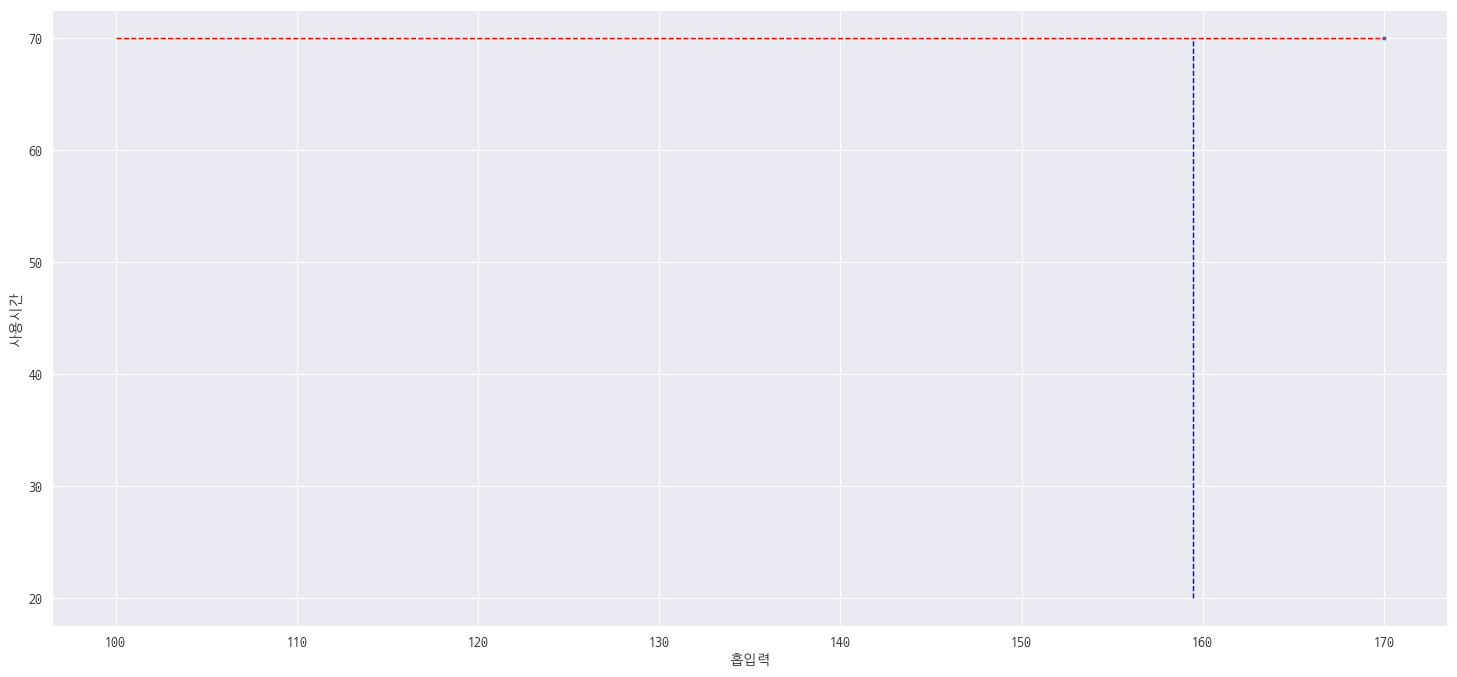

In [183]:
plt.figure(figsize=(18,8))

sns.scatterplot(data=chartData,x='흡입력',y='사용시간',size='가격', sizes=(10,400),hue=chartData['회사명'],legend=False)
plt.plot([100,suctionMax],[useTimeMean2, useTimeMean2], 'r--', lw=1) # 사용시간 평균치 줄표시
plt.plot([suctionMean, suctionMean], [20,useTimeMax], 'b--', lw=1) # 흡입력 평균치 줄표시

plt.show()

In [185]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

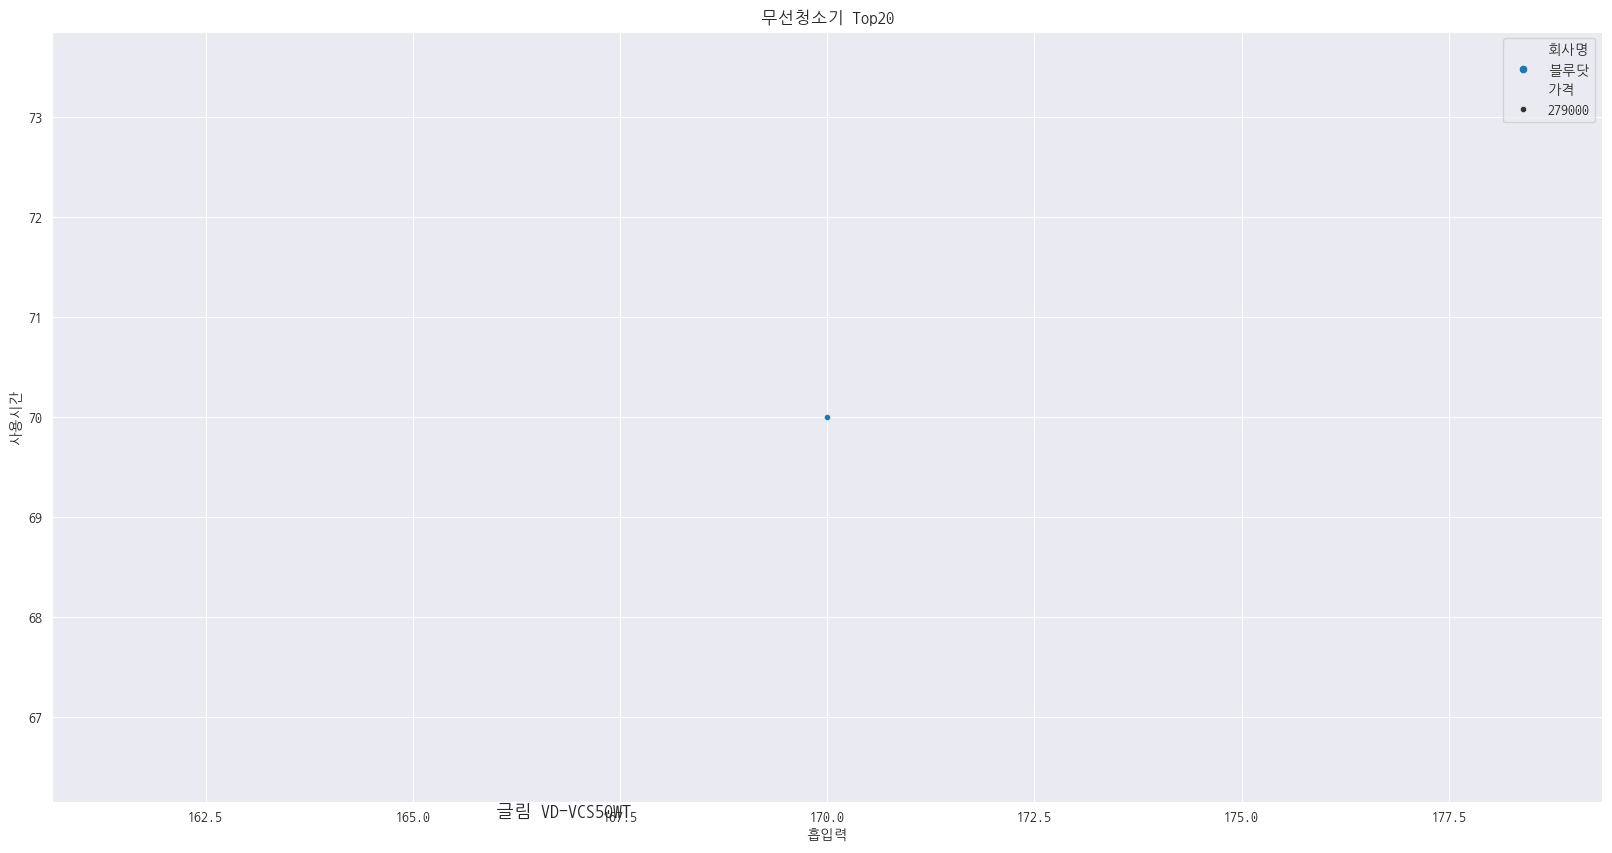

In [191]:
import random

# 인기제품 시각화
fig = plt.figure(figsize=(20,10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20,1000),hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-10,10)
    y = row['사용시간'] + random.randrange(-5,5)
    s = row['제품명']
    plt.text(x,y,s,size=13)

plt.show()

##### 결론
- 데이터 분석을 위한 전처리는 쉽지않음
- 결과들이 예상이나, 실제와 다를 수 있음